# **Drowsiness Detection with Eye Aspect Ratio (EAR)**


---


This script detects drowsiness in real-time using the Eye Aspect Ratio (EAR)
calculated from facial landmarks. It uses dlib for landmark detection and
OpenCV for video processing and visualization.

If the eyes remain closed for a defined number of frames, a drowsiness warning is triggered.

**Requirements:**

- OpenCV (`cv2`)
- dlib
- numpy
- face_landmark_detector.py (custom class)

**Pretrained Model:**

Download the 68-point shape predictor model:
http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2


### **Import Required Libraries**


In [16]:
import cv2
import numpy as np
from face_landmark_detector import FaceLandmarkDetector

---


### **Define Helper Functions**


#### **Define the Eye Aspect Ratio (EAR) Function**


The **Eye Aspect Ratio (EAR)** is a metric used to detect eye closure (blinks or drowsiness). It is calculated using the vertical and horizontal distances between specific eye landmarks.


![eye aspect ratio dlib.jpg](<attachment:eye aspect ratio dlib.jpg>)

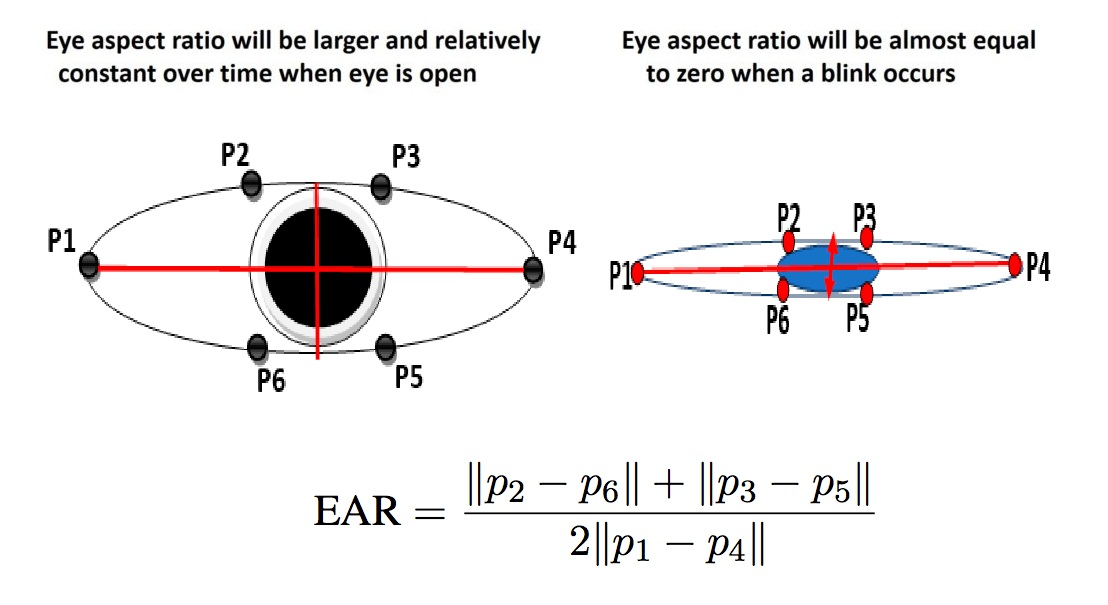

In [17]:
def eye_aspect_ratio(eye: np.ndarray) -> float:
    """
    Compute the Eye Aspect Ratio (EAR) to detect eye closure.
        EAR = (||p2 - p6|| + ||p3 - p5||) / (2 * ||p1 - p4||)


    Args:
        eye (np.ndarray): Array of 6 (x, y) coordinates representing the eye landmarks.

    Returns:
        float: Eye Aspect Ratio (EAR) value.
    """
    # Vertical distances
    vertical_1 = np.linalg.norm(eye[1] - eye[5])
    vertical_2 = np.linalg.norm(eye[2] - eye[4])

    # Horizontal distance
    horizontal = np.linalg.norm(eye[0] - eye[3])

    # EAR formula
    ear = (vertical_1 + vertical_2) / (2.0 * horizontal)
    return ear

#### **Draw Text on Frame**


In [18]:
def put_text(frame, text, position, color=(0, 0, 255), font_scale=0.7, thickness=2):
    cv2.putText(
        frame, text, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness
    )

---


### **Parameters for Drowsiness Detection**


In [19]:
EAR_THRESHOLD = 0.30  # Below this, eye is considered "closed"
CONSECUTIVE_FRAMES_THRESHOLD = 20  # Frames before alert is triggered

frame_counter = 0  # Count how many frames eyes are closed
drowsy = False  # Alert flag

---


### **Real-Time Drowsiness Detection**


In [ ]:
cap = cv2.VideoCapture(0)

# Initialize the FaceLandmarkDetector
detector = FaceLandmarkDetector("../models/shape_predictor_68_face_landmarks.dat")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)

    # Detect facial landmarks and draw them on the frame
    faces_landmarks = detector.detect_landmarks(frame, draw_connections=True)

    if faces_landmarks:
        for face_landmarks in faces_landmarks:
            # Eye indices from face_landmark_detector
            right_eye_idxs = detector.FACIAL_LANDMARKS_IDXS["right_eye"]
            left_eye_idxs = detector.FACIAL_LANDMARKS_IDXS["left_eye"]

            # Extract eye coordinates
            right_eye = face_landmarks[right_eye_idxs[0] : right_eye_idxs[1]]
            left_eye = face_landmarks[left_eye_idxs[0] : left_eye_idxs[1]]

            # Compute EAR
            right_ear = eye_aspect_ratio(right_eye)
            left_ear = eye_aspect_ratio(left_eye)
            ear = (left_ear + right_ear) / 2.0

            put_text(frame, f"EAR: {ear:.2f}", (10, 30), color=(0, 255, 0))

            # Drowsiness check
            if ear < EAR_THRESHOLD:
                frame_counter += 1
                if frame_counter >= CONSECUTIVE_FRAMES_THRESHOLD:
                    drowsy = True
                    put_text(frame, "DROWSY!", (10, 60))
                    print("Drowsiness Detected!")
            else:
                frame_counter = 0
                drowsy = False

    # Show the output frame
    cv2.imshow("Drowsiness Detection", frame)

    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

- EAR < 0.30 → considered eyes closed
- If eyes stay closed for 20 consecutive frames → Drowsiness alert
- Visual feedback is shown on screen in real-time


---
